# Biomedical Image Analysis

**Objective:** Measure the ejection fraction: the proportion of blood ejected from the left ventricle during each stroke.

Code has been updated to support imageio==2.19.2.

## Data
This dataset is drawn from the [Sunnybrook Cardiac Atlas Project](http://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/). It has been de-identified and used as training data in a number of different competitions. This particular subject is a 27-year old male and was diagnosed with "heart failure without infarct". It may be found in the dataset under the ID of SCD0002001, as well as SC-HF-NI-15.  The series description for the included scans was: 1.528_???_-x_-y_256_256_???. They have been modified slightly from the original.

## Imports

In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import imageio
import scipy.ndimage as ndi
print(imageio.__version__)
plt.rcParams['figure.figsize'] = (16, 8)

2.19.2


## Load Data

In [2]:
DATA_PATH = "sunnybrook-cardiac-mr/"

### Metadata

Metadata of medical images include:

- Patient demographics: name, age, sex, clinical information
- Acquisition information: image shape, sampling rates, data type, modality (such as X-Ray, CT or MRI)

In [3]:
#Test Img
testimg = DATA_PATH + '/SCD2001_006/SCD2001_MR_117.dcm'

# Load "chest-220.dcm"
im = imageio.v2.imread(testimg)

# Print image attributes
print('Image type:', type(im))
print('Shape of image array:', im.shape)

# Print the available metadata fields
print(im.meta.keys())

Image type: <class 'imageio.core.util.Array'>
Shape of image array: (256, 256)
odict_keys(['TransferSyntaxUID', 'SOPClassUID', 'SOPInstanceUID', 'StudyDate', 'SeriesDate', 'AcquisitionDate', 'ContentDate', 'StudyTime', 'SeriesTime', 'AcquisitionTime', 'ContentTime', 'Modality', 'Manufacturer', 'StudyDescription', 'SeriesDescription', 'PatientName', 'PatientID', 'PatientBirthDate', 'PatientSex', 'SliceSpacing', 'StudyInstanceUID', 'SeriesInstanceUID', 'SeriesNumber', 'AcquisitionNumber', 'InstanceNumber', 'ImagePositionPatient', 'ImageOrientationPatient', 'SamplesPerPixel', 'Rows', 'Columns', 'PixelSpacing', 'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation', 'PixelData', 'shape', 'sampling'])


## Heart Segmentation

Image of the heart pumping blood we need to extract the left ventricle image.

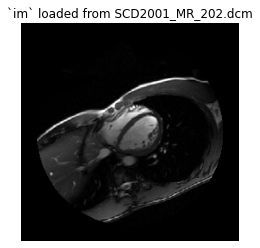

In [4]:
# Draw the image in grayscale
plt.imshow(im, cmap='gray')

# Render the image
plt.axis('off')
plt.title(f"`im` loaded from SCD2001_MR_202.dcm")
plt.show()

In [5]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()

## Segment the left ventricle from a single slice of the volume (im)

1. Filter and mask the image
2. Label each object with ndi.label()

Num. Labels: 26


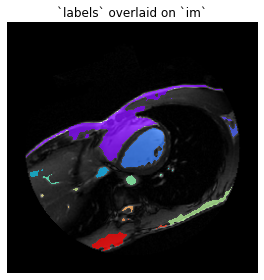

In [6]:
# Smooth intensity values
im_filt = ndi.median_filter(im, size=3)

# Select high-intensity pixels
mask_start = np.where(im_filt>60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)

# Create a `labels` overlay
overlay = np.where(labels>0, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(im, cmap='gray')
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
plt.title(f"`labels` overlaid on `im`")
format_and_render_plot()

## Select Centrally-located left ventricle

Find the label value for the centrally-located left ventricle, and create a mask for it

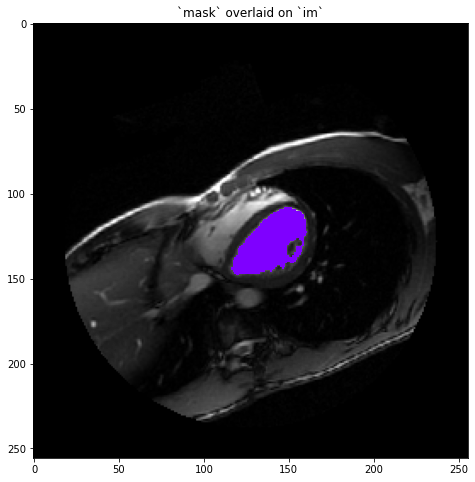

In [17]:
# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, np.nan)

# Overlay selected label
plt.imshow(im, cmap='gray')
plt.imshow(lv_mask, cmap='rainbow')
plt.title(f"`mask` overlaid on `im`")
plt.show()

## Extract Centrally-located left ventricle

Extracting Centrally-located left ventricle from the original image by eliminating unrelated pixels. We achieve this using ndi.find_objects() to create a new image containing with only the left ventricle.

In [ ]:
# Create left ventricle mask
labels, nlabels = ndi.label(mask)
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)

# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

# Crop to the left ventricle (index 0)
im_lv = im[bboxes[0]]

# Plot the cropped image
plt.imshow(im_lv)
format_and_render_plot()